<a href="https://colab.research.google.com/github/nedokormysh/GB_pred-diag/blob/lesson_4_unet/GB_pred%26diag_hw_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Условие


https://www.kaggle.com/datasets/debeshjha1/kvasircapsuleseg
Итоговое задание - выполнить сегментацию полипов согласно приложенного датасета.

1. подготовить данные должным образом.
2. Попробовать различные архитектуры, выбрать наилучшую.
3. Попробовать аугментацию, трансферное обучение.
4. Визуализировать предсказания выбранной модели.
5. Составить обобщающий хороший вывод.
6. (по желанию) сделать API


https://habr.com/ru/companies/otus/articles/442918/ - как делать API для ML

Сдавать как обычно Гитхаб или Гугл колаб.

In [ ]:
import os
from zipfile import ZipFile
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import pandas as pd

import torch
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15, 4)

In [ ]:
# Разархивирование ZIP-архива в указанную директорию
with ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall()

print("Архив успешно разархивирован.")

Архив успешно разархивирован.


# Загрузка данных

In [ ]:
images = []
masks = []
root_dir = 'Kvasir-Capsule'

for current_root, dirs, files in os.walk(root_dir):
    # Пропускаем папку annotated_images и все её поддиректории
    if 'annotated_images' in current_root:
        continue

    for file in files:
        file_path = os.path.join(current_root, file)
        if current_root.endswith('images'):
            images.append(imread(file_path))
        elif current_root.endswith('masks'):
            masks.append(imread(file_path))

Сделаем ресайз

In [ ]:
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in masks]

In [ ]:
len(images), len(masks)

(55, 55)

In [ ]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 55 images


Нарисуем несколько изображений

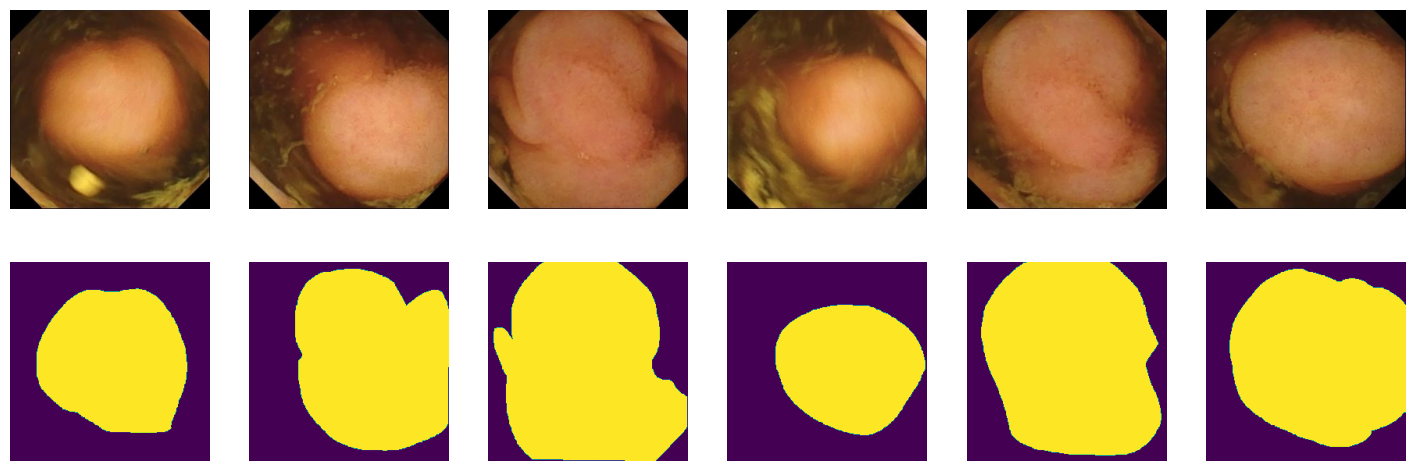

In [ ]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 55 картинок на 27/14/14 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [27, 41])

In [ ]:
len(tr), len(val), len(ts)

(27, 14, 14)

# Dataloader

In [ ]:
batch_size = 10
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур

## Вспомогательные функции

In [ ]:
# фиксируем воспроизводимость
def seed_everything(seed=7575):

    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed=7575)

Метрика - IoU


In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    """
    Функция рассчёта метрики
    """
    # BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Вернёт 0 если Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Вернёт 0 если оба нулю

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # Для избежани неопределённости 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # Сравнение

    return thresholded

Функции потерь:
* DICE
* BCE

In [ ]:
def dice_loss(y_real, y_pred):
    """
    Функция рассчёта dice loss
    """
    y_pred = torch.flatten(torch.sigmoid(y_pred))
    y_real = torch.flatten(y_real)
    num = 2 * torch.sum(y_real * y_pred)
    den =  torch.sum(y_real + y_pred)
    res = 1 - (num / den)
    return res

In [ ]:
def bce_loss(y_real, y_pred):
    """Функция рассчёта бинарной кросс энтропии"""
    y_pred = y_pred.to(device)
    y_real = y_real.to(device)

    return torch.mean(y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred)))

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):

    """Функция обучения"""
    X_val, Y_val = next(iter(data_val))

    train_losses = []
    test_losses = []
    scores = []

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward() # backward-pass
            opt.step()  # update weights

            avg_loss += loss / len(data_tr)
            # train_losses.append(avg_loss)
        train_losses.append(avg_loss)

        toc = time()
        print('loss: %f' % avg_loss)

        # рассчитываем промежуточные результаты
        model.eval()  #
        with torch.no_grad():
            Y_pred = model(X_val.to(device)).detach().cpu()
            Y_hat = torch.sigmoid(Y_pred)
            test_losses.append(loss_fn(Y_val, Y_pred))
            scores.append(score_model(model, iou_pytorch, data_val))

        # визуализация промежуточных результатов
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

    return train_losses, test_losses, scores

In [ ]:
def predict(model, data):
    """Функция прогноза"""
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data, threshold=0.5):
    """Функция рассчёта метрик"""
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        X_batch = X_batch.to(device)
        Y_pred = torch.sigmoid(model(X_batch)) > threshold
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

In [ ]:
def plot(losses_train, losses_val, scores):
  """Функция отрисовки результатов"""
  fig = plt.figure(figsize = (20, 5))
  fig.add_subplot(121)
  plt.plot([x.cpu().detach().numpy() for x in losses_train], label="train_loss",)
  plt.plot([x.cpu().detach().numpy() for x in losses_val], label="val_loss",)
  plt.grid()
  plt.legend()
  fig.add_subplot(122)
  plt.plot(scores, label="score", )
  plt.grid()
  plt.legend()
  plt.show()

  score_max = max(scores)

  print(f' score на валидационной выборке : {score_max}')
  return score_max

## SegNet

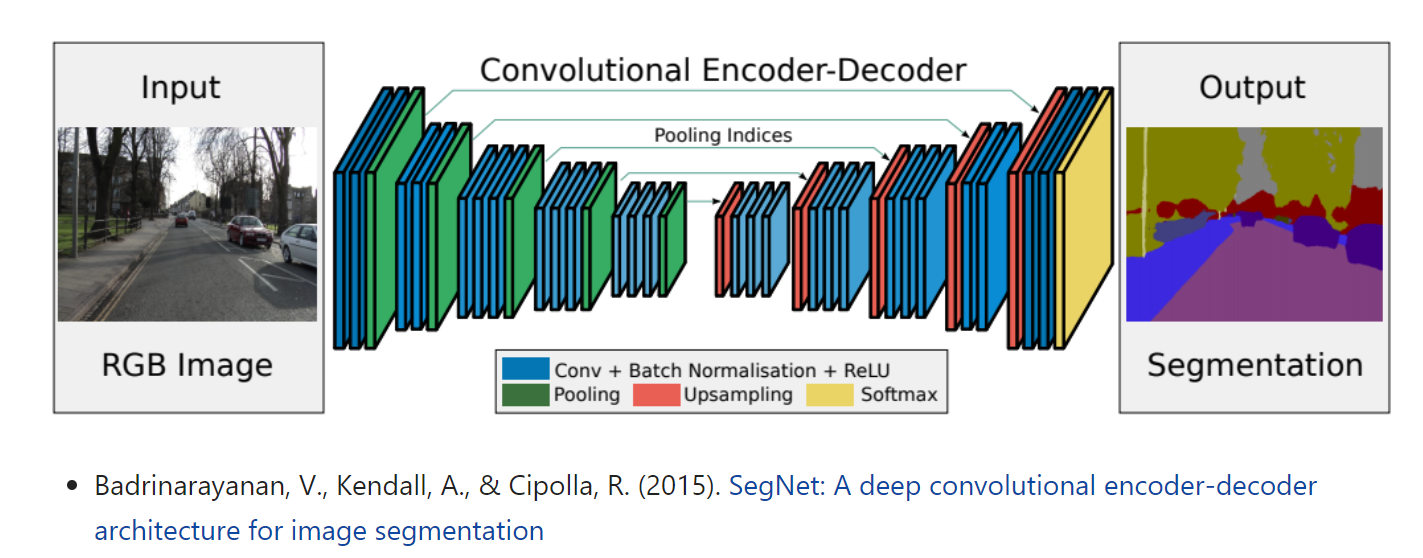

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU(),
                                       nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU())
        self.pool0 = nn.MaxPool2d(kernel_size=2, return_indices=True)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(),
                                       nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU())
        self.pool1 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU(),
                                       nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU())
        self.pool2 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(),
                                       nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU())
        self.pool3 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
                                      nn.BatchNorm2d(512),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
                                      nn.BatchNorm2d(256),
                                      nn.ReLU(inplace=True))

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2,2) # 16 -> 32

        self.dec_conv0 = nn.Sequential(nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
                                      nn.BatchNorm2d(256),
                                      nn.ReLU(),
                                      nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
                                      nn.BatchNorm2d(128),
                                      nn.ReLU())
        self.upsample1 = nn.MaxUnpool2d(2,2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
                                      nn.BatchNorm2d(128),
                                      nn.ReLU(),
                                      nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
                                      nn.BatchNorm2d(64),
                                      nn.ReLU())
        self.upsample2 = nn.MaxUnpool2d(2,2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                                      nn.BatchNorm2d(64),
                                      nn.ReLU(),
                                      nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
                                      nn.BatchNorm2d(32),
                                      nn.ReLU())
        self.upsample3 = nn.MaxUnpool2d(2,2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
                                      nn.BatchNorm2d(32),
                                      nn.ReLU(),
                                      nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, padding=1),
                                      nn.BatchNorm2d(1),
                                      nn.ReLU())

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e0, indices0 = self.pool0(e0)

        e1 = self.enc_conv1(e0)
        e1, indices1 = self.pool0(e1)

        e2 = self.enc_conv2(e1)
        e2, indices2 = self.pool0(e2)

        e3 = self.enc_conv3(e2)
        e3, indices3 = self.pool0(e3)

        # bottleneck
        b = self.bottleneck_conv(e3)

        # # decoder

        d0 = self.upsample0(b, indices3)
        d0 = self.dec_conv0(d0)

        d1 = self.upsample1(d0, indices2)
        d1 = self.dec_conv1(d1)

        d2 = self.upsample2(d1, indices1)
        d2 = self.dec_conv2(d2)

        d3 = self.upsample3(d2, indices0)
        d3 = self.dec_conv3(d3)   # no activation

        return d3

### Тренировка BCE

In [ ]:
df_results = pd.DataFrame(columns=['model', 'loss_function', 'score'])
# df_results

In [ ]:
MAX_EPOCHS = 40

In [ ]:
model_bce = SegNet().to(device)

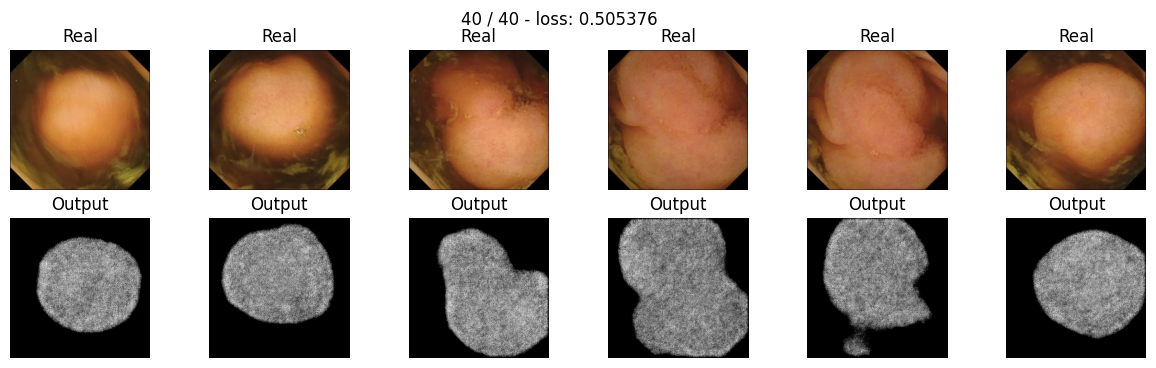

In [ ]:
max_epochs = MAX_EPOCHS
optim = torch.optim.Adam(model_bce.parameters(), lr=1e-4)
losses_train_segnet_bce, losses_val_segnet_bce, scores_segnet_bce = train(model_bce, optim, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_bce, iou_pytorch, data_val)

0.7800000309944153

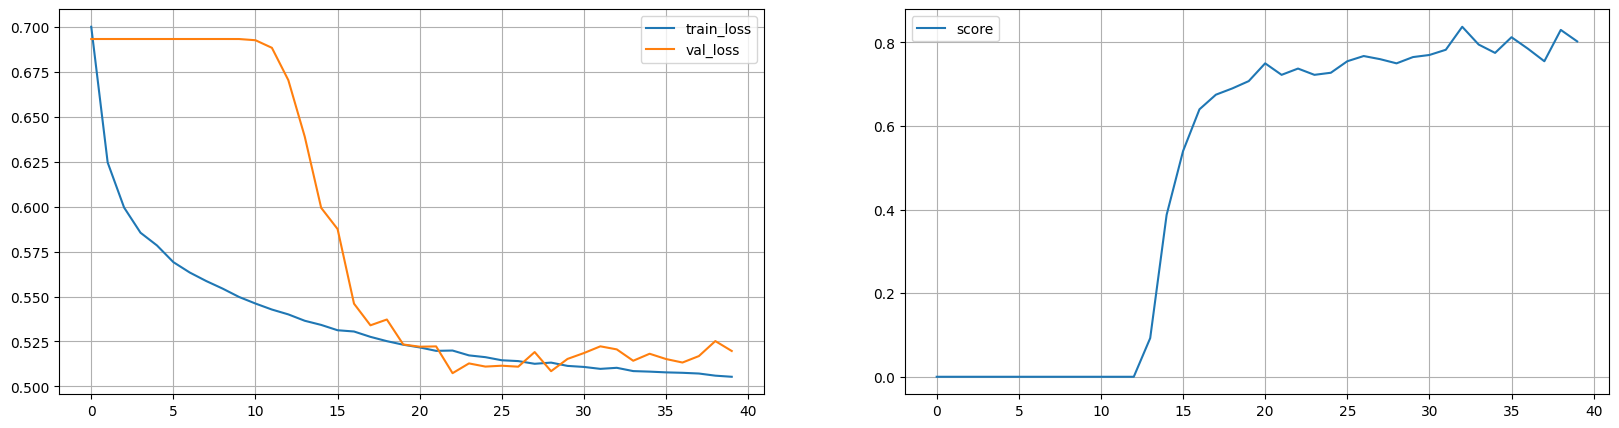

 score на валидационной выборке : 0.8375000357627869


In [ ]:
max_score_val = plot(losses_train_segnet_bce, losses_val_segnet_bce, scores_segnet_bce)

In [ ]:
df_results = pd.concat([pd.DataFrame([['SegNet', 'bce_loss', max_score_val]], columns=df_results.columns), df_results], ignore_index=True)
# df_results

**Выводы:**
- В принципе, пусть лосс на трейне даже к 40 эпохе продолжает снижаться, то и на валидацонном лосе и на IoU метрике мы могли останавливаться на примерно 30-ой эпохе

### Тренировка DICE

посмотрим SegNet, но с другой функцией потерь

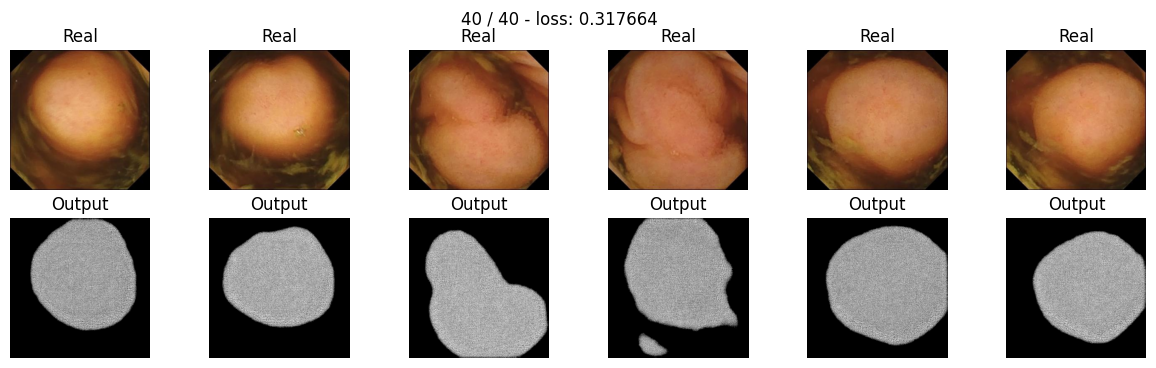

In [ ]:
model_dice = SegNet().to(device)

max_epochs = MAX_EPOCHS
optimaizer = torch.optim.Adam(model_dice.parameters(), lr=1e-4)
losses_train_segnet_dice, losses_val_segnet_dice, scores_segnet_dice = train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_dice, iou_pytorch, data_val)

0.7825000286102295

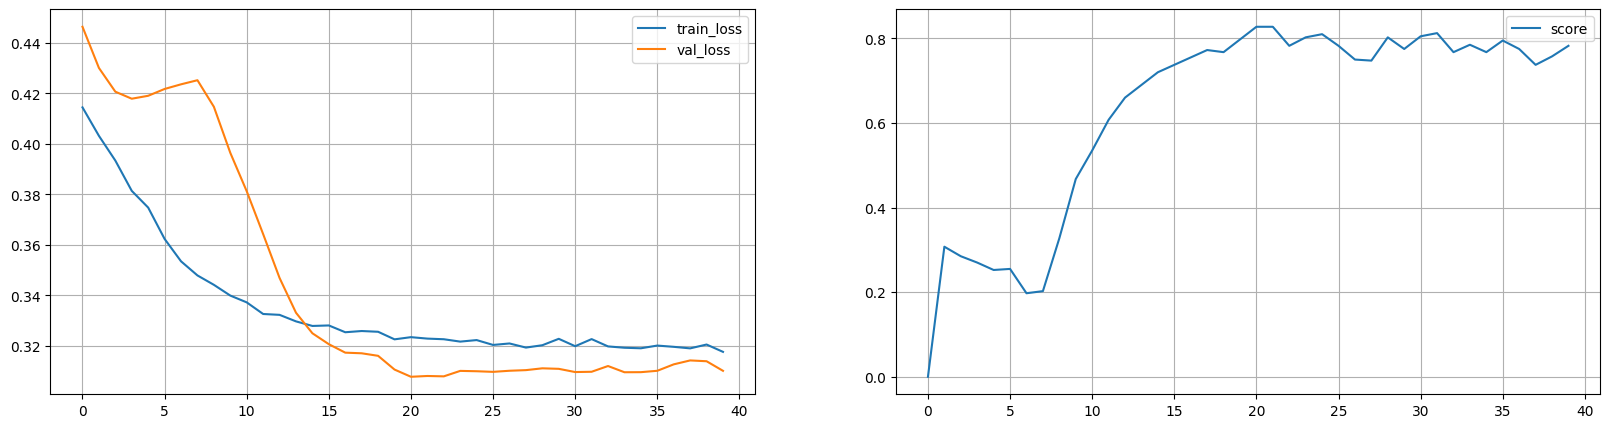

 score на валидационной выборке : 0.8275000154972076


In [ ]:
max_score_val = plot(losses_train_segnet_dice, losses_val_segnet_dice, scores_segnet_dice)
df_results = pd.concat([pd.DataFrame([['SegNet', 'dice', max_score_val]], columns=df_results.columns), df_results], ignore_index=True)

**Выводы:**
- больших изменений результатов по метрикам не увидел
- хотя на первых эпохах модель с bce вела себя более равномерно

## U-Net 1

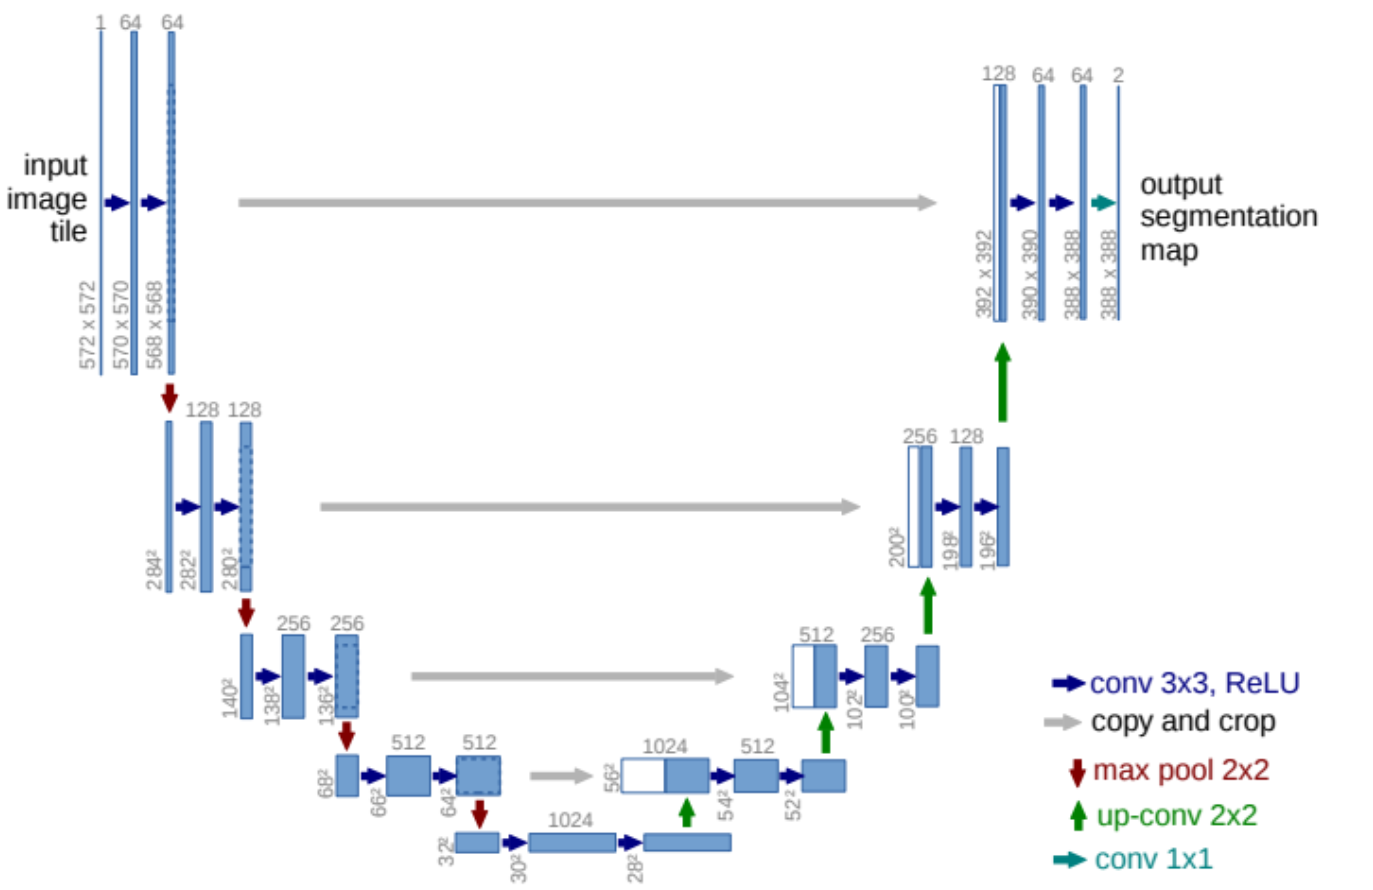

In [ ]:
def double_conv(in_channels, out_channels):
  """
  Функция свёрточного слоя. 2 операций свертки, нормализации и активации
  """
  conv = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
      nn.BatchNorm2d(out_channels),
      # nn.ReLU(inplace=True),
      nn.ReLU(),
      nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
      nn.BatchNorm2d(out_channels),
      # nn.ReLU(inplace=True)
      nn.ReLU(),
  )
  return conv

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = double_conv(3, 32)
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)  # 256 -> 128
        self.enc_conv1 = double_conv(32, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 128 -> 64
        self.enc_conv2 = double_conv(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64 -> 32
        self.enc_conv3 = double_conv(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = double_conv(256, 512)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(32)  # 16 -> 32
        self.dec_conv0 = double_conv(512+256, 256)
        self.upsample1 = nn.Upsample(64) # 32 -> 64
        self.dec_conv1 = double_conv(256+128, 128)
        self.upsample2 = nn.Upsample(128) # 64 -> 128
        self.dec_conv2 = double_conv(128+64, 64)
        self.upsample3 = nn.Upsample(256) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
                              nn.Conv2d(in_channels=64 + 32, out_channels=32, kernel_size=3, padding=1),
                              nn.BatchNorm2d(32),
                              # # nn.ReLU(inplace=True),
                              nn.ReLU(),
                              nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1)
                              )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3))

        # decoder
        d0 = self.upsample0(b)
        d0 = torch.cat([d0, e3], dim=1)
        d0 = self.dec_conv0(d0)

        d1 = self.upsample1(d0)
        d1 = torch.cat([d1, e2], dim=1)
        d1 = self.dec_conv1(d1)

        d2 = self.upsample2(d1)
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec_conv2(d2)

        d3 = self.upsample3(d2)
        d3 = torch.cat([d3, e0], dim=1)
        d3 = self.dec_conv3(d3)  # no activation
        return d3

In [ ]:
unet_model = UNet().to(device)

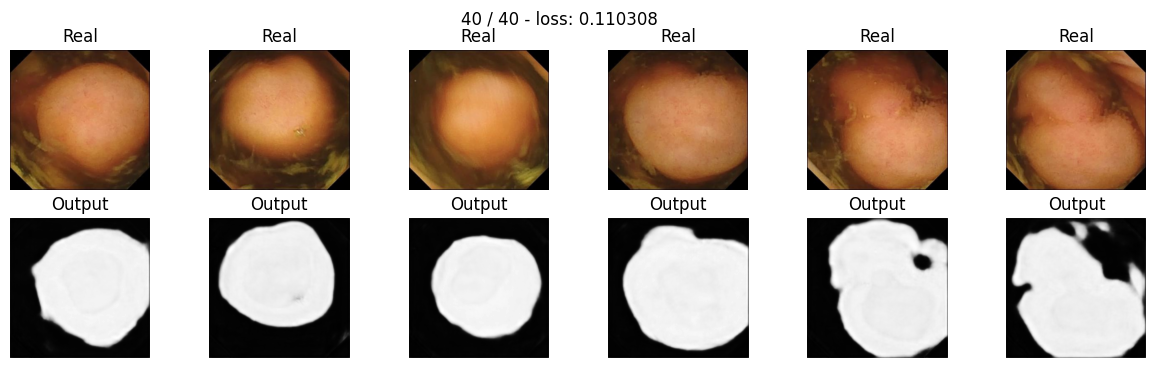

In [ ]:
max_epochs = MAX_EPOCHS
optimizer = torch.optim.Adam(unet_model.parameters(), lr=1e-4)
losses_train_unet_1_bce, losses_test_unet_1_bce, scores_unet_1_bce = train(unet_model, optimizer, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(unet_model, iou_pytorch, data_val)

0.8225000202655792

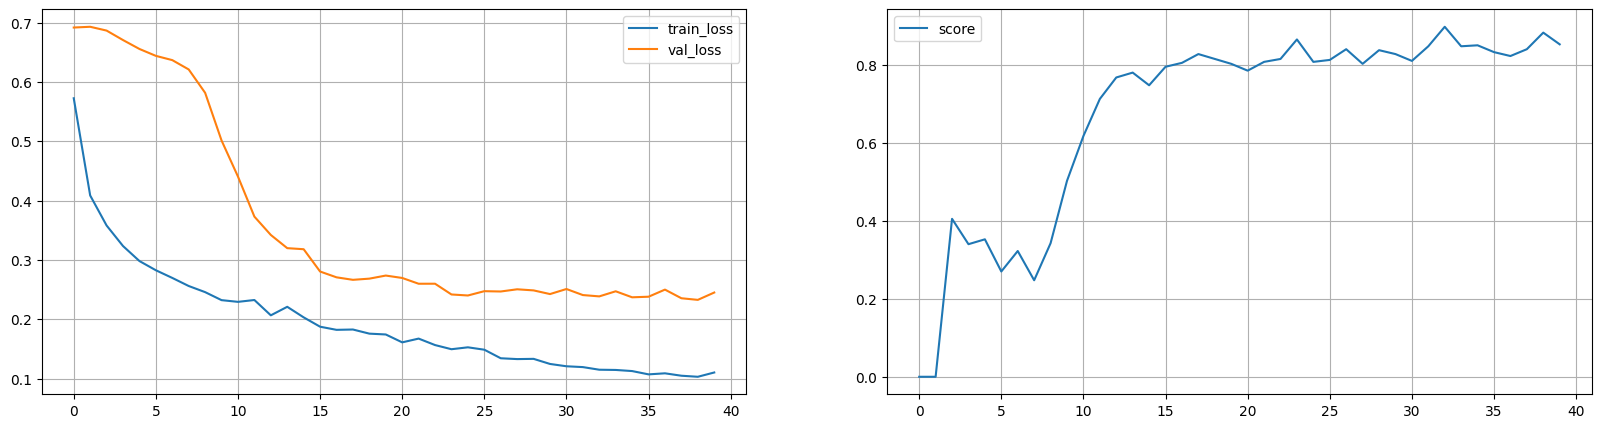

 score на валидационной выборке : 0.8975000083446503


In [ ]:
max_score_val = plot(losses_train_unet_1_bce, losses_test_unet_1_bce, scores_unet_1_bce)
df_results = pd.concat([pd.DataFrame([['Unet_1', 'bce_loss', max_score_val]], columns=df_results.columns), df_results], ignore_index=True)

**Выводы:**
- результаты лучше, чем в SegNet
- лосс сильно лучше на обучающей выборке, чем в SegNet. Но по метрикам и лоссу на валидационной выборке - уже не такие сильные различия

## U-Net 2

Изменим тип пулинга. Точнее заменим maxpooling на convolution при downsampling и transpose-convolutions при upsampling.

In [ ]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = double_conv(3, 32)
        self.pool0 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=2, stride=2)    # 256 -> 128
        self.enc_conv1 = double_conv(32, 64)
        self.pool1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=2)   # 128 -> 64
        self.enc_conv2 = double_conv(64, 128)
        self.pool2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, stride=2)   # 64 -> 32
        self.enc_conv3 = double_conv(128, 256)
        self.pool3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=2, stride=2)   # 32 -> 16

        # bottleneck
        self.bottleneck_conv = double_conv(256, 512)

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2)  # 16 -> 32
        self.dec_conv0 = double_conv(512+256, 256)
        self.upsample1 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = double_conv(256+128, 128)
        self.upsample2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2) # 64 -> 128
        self.dec_conv2 = double_conv(128+64, 64)
        self.upsample3 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
                              nn.Conv2d(in_channels=64 + 32, out_channels=32, kernel_size=3, padding=1),
                              nn.BatchNorm2d(32),
                              # # nn.ReLU(inplace=True),
                              nn.ReLU(),
                              nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1)
                              )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3))

        # decoder
        d0 = self.upsample0(b)
        d0 = torch.cat([d0, e3], dim=1)
        d0 = self.dec_conv0(d0)

        d1 = self.upsample1(d0)
        d1 = torch.cat([d1, e2], dim=1)
        d1 = self.dec_conv1(d1)

        d2 = self.upsample2(d1)
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec_conv2(d2)

        d3 = self.upsample3(d2)
        d3 = torch.cat([d3, e0], dim=1)
        d3 = self.dec_conv3(d3)  # no activation
        return d3

In [ ]:
unet2_model = UNet2().to(device)

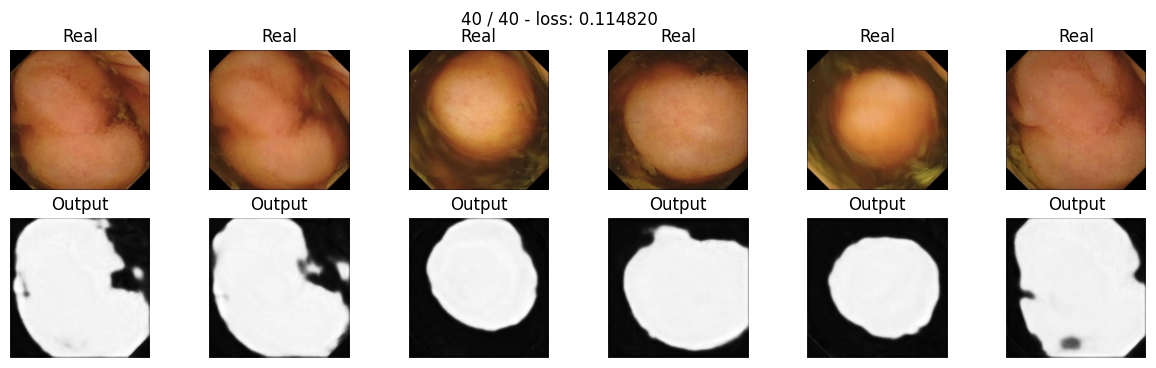

In [ ]:
max_epochs = MAX_EPOCHS
optimizer = torch.optim.Adam(unet2_model.parameters(), lr=1e-4)
losses_train_unet_2_bce, losses_test_unet_2_bce, scores_unet_2_bce = train(unet2_model, optimizer, bce_loss, max_epochs, data_tr, data_val)

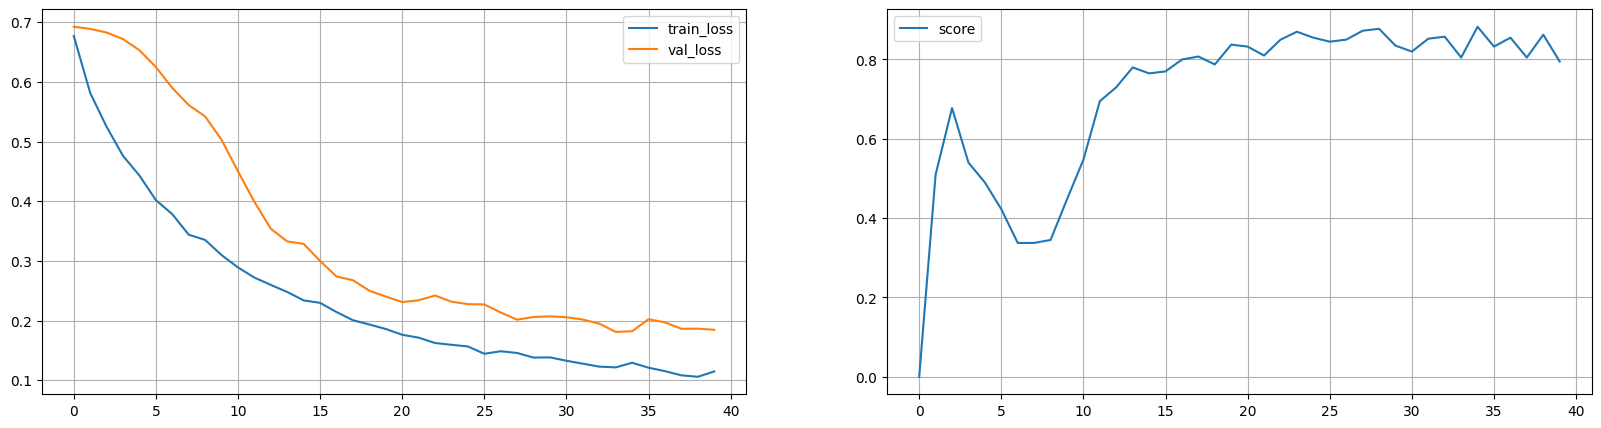

 score на валидационной выборке : 0.882500022649765


In [ ]:
max_score_val = plot(losses_train_unet_2_bce, losses_test_unet_2_bce, scores_unet_2_bce)
df_results = pd.concat([pd.DataFrame([['Unet_2', 'bce_loss', max_score_val]], columns=df_results.columns), df_results], ignore_index=True)

**Выводы:**
- результат не то, чтобы сильно отличается от U-Net с maxpooling

## Трансферное обучение

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset

### аугментация

аугментируем изображения

In [ ]:
# Определяем трансформации
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Resize(256, 256),
    ToTensorV2()
])

In [ ]:
# Создаем кастомный Dataset для PyTorch
class PolypDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        return image, mask

In [ ]:
# Создаем датасеты
dataset = PolypDataset(X, Y, transform=transform)

# Пересчитываем индексы для правильного разделения
train_length = len(tr)
val_length = len(val)
test_length = len(ts)

# Проверим, что сумма длин совпадает с длиной датасета
assert train_length + val_length + test_length == len(dataset), "Сумма длин не совпадает с длиной датасета"

# Разделение на обучающую, валидационную и тестовую выборки
lengths = [train_length, val_length, test_length]
train_dataset, val_dataset, test_dataset = random_split(dataset, lengths)

# Даталоадеры
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
!pip install segmentation-models-pytorch -q

In [ ]:
import segmentation_models_pytorch as smp

In [ ]:
# Задаем модель UNet с предобученным энкодером
model_transfer = smp.Unet(
    encoder_name="resnet34",        # Используем предобученный ResNet34
    encoder_weights="imagenet",     # Загрузим веса, предобученные на ImageNet
    in_channels=3,                  # Число каналов входного изображения (RGB)
    classes=1,                      # Число классов на выходе (1 для бинарной сегментации)
)

In [ ]:
model_transfer.to(device);

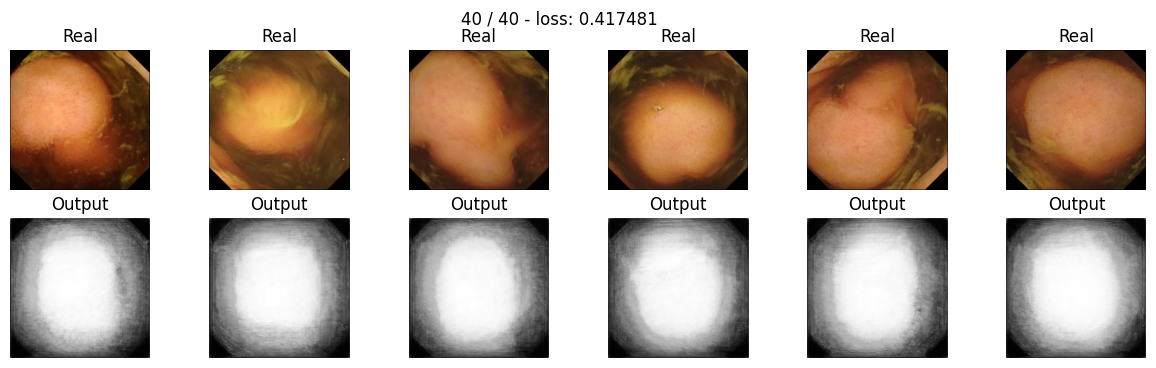

In [ ]:
max_epochs = MAX_EPOCHS
optimizer = torch.optim.Adam(model_transfer.parameters(), lr=1e-4)
losses_train_unet_3_transfer, losses_test_unet_3_transfer_bce, scores_unet_3_transfer_bce = train(model_transfer, optimizer, bce_loss, MAX_EPOCHS, train_loader, val_loader)

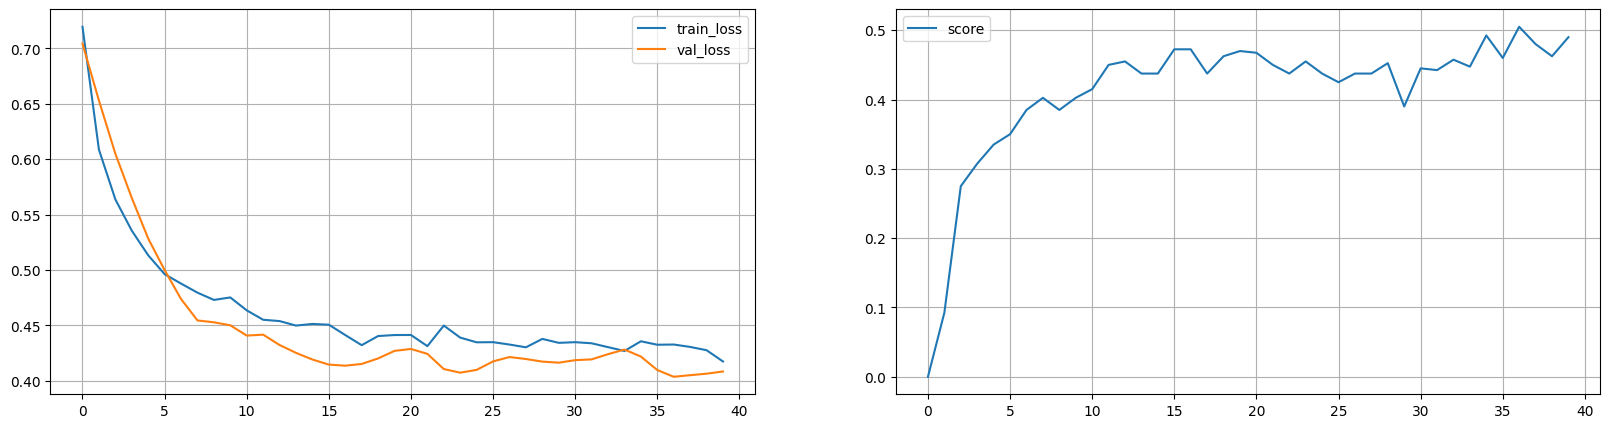

 score на валидационной выборке : 0.5050000101327896


In [ ]:
max_score_val = plot(losses_train_unet_3_transfer, losses_test_unet_3_transfer_bce, scores_unet_3_transfer_bce)
df_results = pd.concat([pd.DataFrame([['Unet_transf_aug', 'bce_loss', max_score_val]], columns=df_results.columns), df_results], ignore_index=True)

**Выводы:**
- аугментация исходных изображений только ухудшила результаты
- возможно следовало как-то добавить аугментированные изображения в датасет или использовать другие варианты трансформации
- либо где-то ошибка в аугментации

### без аугментации

In [ ]:
# Задаем модель UNet с предобученным энкодером
model_transfer = smp.Unet(
    encoder_name="resnet34",        # Используем предобученный ResNet34
    encoder_weights="imagenet",     # Загрузим веса, предобученные на ImageNet
    in_channels=3,                  # Число каналов входного изображения (RGB)
    classes=1,                      # Число классов на выходе (1 для бинарной сегментации)
)

model_transfer.to(device);

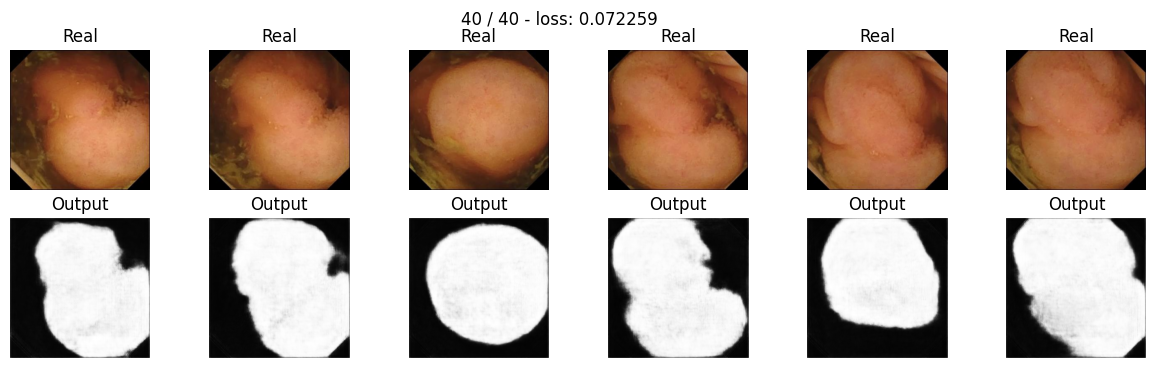

In [ ]:
max_epochs = MAX_EPOCHS
optimizer = torch.optim.Adam(model_transfer.parameters(), lr=1e-4)
losses_train_unet_3_transfer, losses_test_unet_3_transfer_bce, scores_unet_3_transfer_bce = train(model_transfer, optimizer, bce_loss, MAX_EPOCHS,  data_tr, data_val)

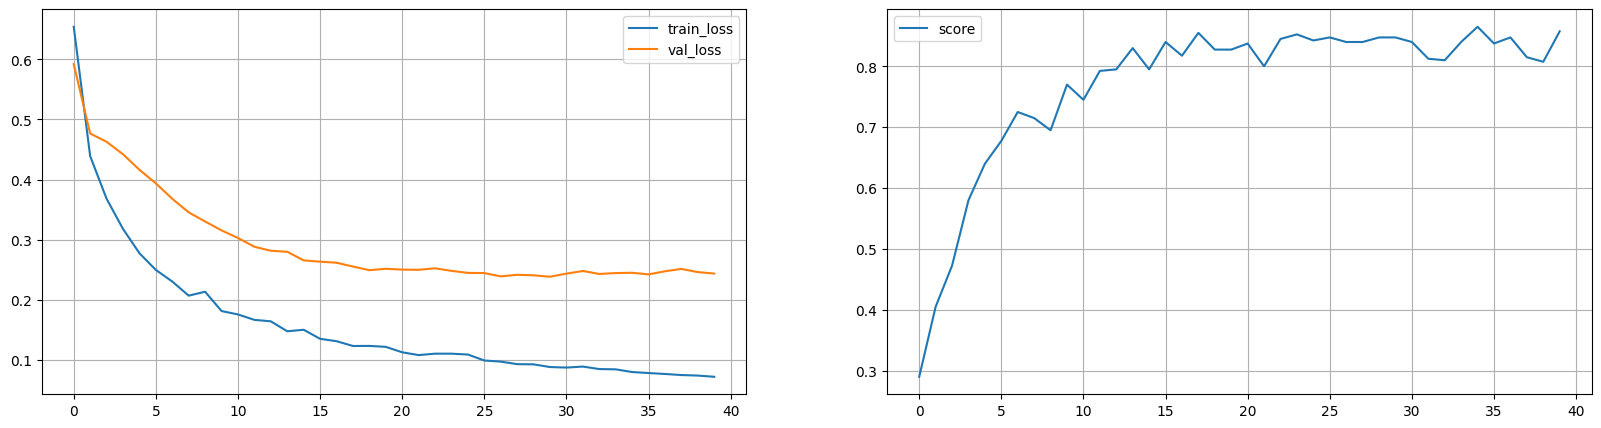

 score на валидационной выборке : 0.8650000393390656


In [ ]:
max_score_val = plot(losses_train_unet_3_transfer, losses_test_unet_3_transfer_bce, scores_unet_3_transfer_bce)
df_results = pd.concat([pd.DataFrame([['Unet_trans_no_aug', 'bce_loss', max_score_val]], columns=df_results.columns), df_results], ignore_index=True)

**Выводы:**
- получили достаточно хорошие результаты

# Результаты

In [ ]:
df_results.set_index('model', inplace=True)

лучшие скоры, полученные моделями

In [ ]:
sorted = df_results.sort_values(by='score', ascending=False)
round(sorted, 5)

,loss_function,score
model,,
Unet_1,bce_loss,0.8975
Unet_2,bce_loss,0.8825
Unet_trans_no_aug,bce_loss,0.8650
SegNet,bce_loss,0.8375
SegNet,dice,0.8275
Unet_transf_aug,bce_loss,0.5050


**Выводы:**
- мы построили две архитектуры U-Net и Segnet.
- посмотрели работу SegNet с разными фунцкциями потерь
- посмотрели работу U-Net с разными вариантами пулинга.
- также использованили трансферное обучение
- лучше всего себя показала модель U-Net c maxpooling.